## Analysing German Dataset and training RF

In [3]:
from ucimlrepo import fetch_ucirepo 
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, f1_score

### Get + Prepare Data

In [94]:
# Read German dataset using fetch_ucirepo lib
statlog_german_credit_data = fetch_ucirepo(id=144)
X = statlog_german_credit_data.data.features 
y = statlog_german_credit_data.data.targets 
df_original = pd.concat([X,y], axis=1)

# Prepare data
target_column_name = 'class'
X = df_original.drop(columns=[target_column_name])
y = df_original[target_column_name]
y = y.map({2:0, 1: 1}) # 2 for bad and 1 for good --> 0 for bad and 1 for good
X = pd.get_dummies(X, drop_first=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Oversample class 0 (bad)
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

# Let class 0 (bad) be with '5' weight, since class is undersampled
# class_weights = {0:5, 1:1}
class_weights = 'balanced'

### Grid Search: choosing best params

In [95]:
# Search for best params
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [2, 4],
    'max_features': ['sqrt', 'log2']
}
rf = RandomForestClassifier(class_weight=class_weights, random_state=42, n_jobs=-1)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                           scoring='f1_macro', cv=5, verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)
results_df = pd.DataFrame(grid_search.cv_results_).sort_values(by="mean_test_score", ascending=False)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


In [96]:
TOP_N = 10
top_params = results_df.head(TOP_N)
top_params[[c for c in top_params.columns if c.startswith('param_')] + ['mean_test_score','std_test_score']].reset_index()

,index,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,mean_test_score,std_test_score
0,8,20,log2,2,2,50,0.795283,0.113967
1,11,20,log2,2,5,100,0.790967,0.119902
2,9,20,log2,2,2,100,0.788552,0.115506
3,5,20,sqrt,4,2,100,0.787121,0.108489
4,7,20,sqrt,4,5,100,0.787121,0.108489
5,3,20,sqrt,2,5,100,0.786957,0.120201
6,10,20,log2,2,5,50,0.784773,0.122094
7,13,20,log2,4,2,100,0.782002,0.120405
8,15,20,log2,4,5,100,0.782002,0.120405
9,12,20,log2,4,2,50,0.780064,0.133295


In [97]:
"""CHOOSE PARAMS FOR RF"""
# params = {} # Default
params = top_params['params'].iloc[0]

### Testing different NUM_FEATURES and THRESHOLD values

In [60]:
thresholds = np.arange(0.5, 0.66, 0.05)
num_features = np.arange(13, 14 + 1, 1)

accuracy_results = np.zeros((len(thresholds), len(num_features)))
f1_class0_results = np.zeros((len(thresholds), len(num_features)))
f1_class1_results = np.zeros((len(thresholds), len(num_features)))

for i, threshold in enumerate(tqdm(thresholds)):
    for j, n_features in enumerate(num_features):
        # Select top N features
        top_features = importance_df.head(n_features)
        X_train_reduced = X_train[top_features['Feature']]
        X_test_reduced = X_test[top_features['Feature']]

        # Train the model with reduced features
        rf_reduced = RandomForestClassifier(class_weight=class_weights, random_state=42, n_jobs=-1)
        rf_reduced.fit(X_train_reduced, y_train)
        
        # Predict with the given threshold
        y_pred_prob = rf_reduced.predict_proba(X_test_reduced)[:, 1]
        y_pred = (y_pred_prob >= threshold).astype(int)
        
        # Compute metrics
        accuracy_results[i, j] = accuracy_score(y_test, y_pred)
        f1_class0_results[i, j] = f1_score(y_test, y_pred, pos_label=0)
        f1_class1_results[i, j] = f1_score(y_test, y_pred, pos_label=1)

%matplotlib widget
# Plot the 3D graph for accuracy and F1 scores
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')

T, F = np.meshgrid(thresholds, num_features, indexing='ij')

ax.plot_surface(T, F, accuracy_results, cmap="Blues", alpha=0.6)
ax.plot_surface(T, F, f1_class0_results, cmap="Reds", alpha=0.6)
ax.plot_surface(T, F, f1_class1_results, cmap="Greens", alpha=0.6)

ax.set_xlabel('Threshold')
ax.set_ylabel('Number of Features')
ax.set_zlabel('Metric Value')
ax.set_title('Performance Metrics vs Threshold and Number of Features')

plt.show()

100%|██████████| 4/4 [00:01<00:00,  3.16it/s]


### Running RF with chosen params

In [104]:
rf = RandomForestClassifier(**params, class_weight=class_weights, random_state=42)
rf.fit(X_train, y_train)

# Get feature importance
importances = rf.feature_importances_
feature_names = X.columns

importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances}).sort_values(by='Importance', ascending=False)

N_FEATURES = 11
THRESHOLD = 0.55

top_features = importance_df.head(N_FEATURES)

X_train_reduced = X_train[top_features['Feature']]
X_test_reduced = X_test[top_features['Feature']]

# Train the model again with reduced features
rf_reduced = RandomForestClassifier(**params, class_weight=class_weights, random_state=42)
rf_reduced.fit(X_train_reduced, y_train)
# Predict
if THRESHOLD:
    y_pred_prob = rf_reduced.predict_proba(X_test_reduced)[:, 1]
    y_pred = (y_pred_prob >= THRESHOLD).astype(int)
else:
    y_pred = rf_reduced.predict(X_test_reduced)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.56      0.66      0.60        59
           1       0.85      0.78      0.81       141

    accuracy                           0.74       200
   macro avg       0.70      0.72      0.71       200
weighted avg       0.76      0.74      0.75       200



### Transforming data to Human-readable format

In [105]:
base_features = list(set(feature.split('_')[0] for feature in top_features['Feature']))

to_remove = [
    'Attribute4'
]

base_features = [f for f in base_features if f not in to_remove]

In [106]:
feature_transformations = {
    "Attribute1": {
        "new_name": "Bank account status",
        "value_mapping": {
            "A14": "No account in bank",
            "A11": "Bank account value < 0 $",
            "A12": "Bank account value > 0 $",
            "A13": "Bank account value > 2000 $",
        },
    },
    "Attribute6": {
        "new_name": "Savings account status",
        "value_mapping": {
            "A65": "No savings account in bank",
            "A61": "Savings < 1000 $",
            "A62": "Savings 1000-5000 $",
            "A63": "Savings > 5000 $",
            "A64": "Savings > 5000 $",
        },
    },
    "Attribute3": {
        "new_name": "Credit history",
        "value_mapping": {
            "A30": "No credits taken",
            "A31": "All credits paid duly at this bank",
            "A32": "Existing credits paid duly till now",
            "A33": "Delay in paying off in the past",
            "A34": "Established but risky credit history",
        },
    },
    "Attribute15": {
        "new_name": "Housing status",
        "value_mapping": {
            "A151": "Rented",
            "A152": "Owned",
            "A153": "Living with parents",
        },
    },
    "Attribute9": {
        "new_name": "Personal status and sex",
        "value_mapping": {
            "A91": "Male: divorced/separated/married",
            "A92": "Female: divorced/separated/married",
            "A93": "Male: single",
            "A94": "Male: divorced/separated/married",
            "A95": "Female: single",
        },
    },
    "Attribute14": {
        "new_name": "Other credits",
        "value_mapping": {
            "A141": "Has other credits",
            "A142": "Has other credits",
            "A143": "Has no other credits",
        },
    },
    "Attribute5": {"new_name": "Credit amount (applicant has requested)"},
    "Attribute13": {"new_name": "Age (in years)"},
    "Attribute8": {"new_name": "Installment rate: % of income used for loan payments"},
    "Attribute2": {"new_name": "Loan duration (months)"},
}


df_cut = df_original[base_features].copy()
for c in df_cut.columns:
    mapping = feature_transformations[c]
    if 'value_mapping' in mapping:
        df_cut[mapping['new_name']] = df_cut[c].map(mapping['value_mapping'])
    else:
        # Specific transformation for Credit amount (rounding and scaling)
        if mapping['new_name'] == "Credit amount (applicant has requested)":
            df_cut[mapping['new_name']] = (df_cut[c].round(-1) * 10).astype(int)
        else:
            df_cut[mapping['new_name']] = df_cut[c]
    
df_cut.drop(base_features, axis=1, inplace=True)
df_cut['class'] = df_original['class'].map({2:0, 1: 1})

### Getting good samples

In [108]:
"""Train tree on this data"""

target_column_name = 'class'
X_cut = df_cut.drop(columns=[target_column_name])
y_cut = df_cut[target_column_name]

X_cut = pd.get_dummies(X_cut, drop_first=True)
X_cut_train, X_cut_test, y_cut_train, y_cut_test = train_test_split(X_cut, y_cut, test_size=0.2, random_state=42)

# Oversample class 0 (bad)
smote = SMOTE(random_state=42)
X_cut_train, y_cut_train = smote.fit_resample(X_cut_train, y_cut_train)

params_cut = params
rf_cut = RandomForestClassifier(**params_cut, class_weight='balanced', random_state=42)
rf_cut.fit(X_cut_train, y_cut_train)

RandomForestClassifier(class_weight='balanced', max_depth=20,
                       max_features='log2', min_samples_leaf=2, n_estimators=50,
                       random_state=42)

In [ ]:
# # Load saved model
# import pickle
# with open('data/models/RandomForestClassifier_for_german.pkl', 'rb') as file:
#     german_model = pickle.load(file)
#     threshold = german_model['threshold']
#     rf_cut = german_model['model']

In [117]:
THRESHOLD = 0.60

# Reorder the columns of X_cut_test to match rf_cut.feature_names_in_
X_cut_test = X_cut_test.reindex(columns=rf_cut.feature_names_in_)

if THRESHOLD:
    y_pred_prob = rf_cut.predict_proba(X_cut_test)[:, 1]
    y_pred = (y_pred_prob >= THRESHOLD).astype(int)
else:
    y_pred = rf_cut.predict(X_cut_test)

print(classification_report(y_cut_test, y_pred))

              precision    recall  f1-score   support

           0       0.54      0.73      0.62        59
           1       0.87      0.74      0.80       141

    accuracy                           0.74       200
   macro avg       0.71      0.74      0.71       200
weighted avg       0.77      0.74      0.75       200



In [ ]:
# import pickle
# model_to_save = {'model': rf_cut,
#                  'params': params,
#                  'classification_report': classification_report(y_cut_test, y_pred),
#                  'threshold': 0.65,
#                  'base_features': base_features,
#                  'feature_transformations': feature_transformations}

# with open("data/models/RandomForestClassifier_for_german.pkl", "wb") as file:
#     pickle.dump(model_to_save, file)

In [121]:
"""Get NUM_SAMPLES_PER_CLASS number of samples per class that wereclassified correctly with proba > CONFIDENCE_THRESHOLD"""
CONFIDENCE_THRESHOLD_1 = 0.9
CONFIDENCE_THRESHOLD_0 = 0.7
NUM_SAMPLES_PER_CLASS = 5

# Reorder the columns of X_cut to match rf_cut.feature_names_in_
X_cut = X_cut.reindex(columns=rf_cut.feature_names_in_)

y_pred_prob = rf_cut.predict_proba(X_cut)
y_pred = (y_pred_prob[:, 1] >= THRESHOLD).astype(int)

best_samples = {c:[] for c in np.unique(y_cut)}

# Find indices where RF is confident and correct
correct_indices = np.where(y_pred == y_cut)[0]
for i in correct_indices:
    real_class = y_cut.iloc[i]
    proba = y_pred_prob[i][real_class]
    if real_class == 1:
        conf_thresh = CONFIDENCE_THRESHOLD_1
    else:
        conf_thresh = CONFIDENCE_THRESHOLD_0
    if proba > conf_thresh:
        best_samples[real_class].append(i)

class_0_samples = best_samples[0][:NUM_SAMPLES_PER_CLASS]
class_1_samples = best_samples[1][:NUM_SAMPLES_PER_CLASS]

class_0_samples, class_1_samples

([1, 4, 9, 10, 11], [2, 8, 16, 20, 24])

In [86]:
ID = 170
rf_cut.predict_proba(X_cut.iloc[ID:ID+1])[0]

array([0.86217867, 0.13782133])

### Analysing feature importance

In [87]:
df_cut.columns

Index(['Personal status and sex', 'Housing status', 'Loan duration (months)',
       'Other credits', 'Installment rate: % of income used for loan payments',
       'Credit history', 'Bank account status', 'Age (in years)',
       'Credit amount (applicant has requested)', 'Savings account status',
       'class'],
      dtype='object')

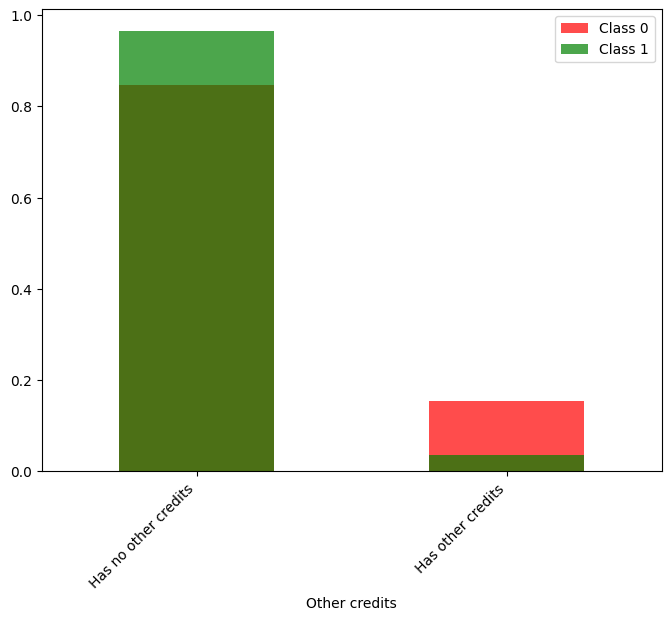

In [135]:
feature = 'Other credits'

# Set figure size and font size
plt.figure(figsize=(8, 6))
plt.rcParams.update({'font.size': 10})

# INDICATIVE SAMPLES
values_class_0 = df_cut.iloc[best_samples[0]][feature].value_counts(normalize=True).sort_index()
values_class_1 = df_cut.iloc[best_samples[1]][feature].value_counts(normalize=True).sort_index()

# ALL SAMPLES
# values_class_0 = df_cut[df_cut['class']==0][feature].value_counts(normalize=True).sort_index()
# values_class_1 = df_cut[df_cut['class']==1][feature].value_counts(normalize=True).sort_index()

# Plot normalized histograms for each class
values_class_0.plot(
    kind='bar', alpha=0.7, label='Class 0', color='red'
)
values_class_1.plot(
    kind='bar', alpha=0.7, label='Class 1', color='green'
)

plt.legend()
plt.xticks(rotation=45, ha='right')  # Rotate 45 degrees and align to the right

plt.show()

In [89]:
# GPT query for analysis
{
    'feature_name': feature,
    'values_class_0': values_class_0.to_dict(),
    'values_class_1': values_class_1.to_dict(),
}

{'feature_name': 'Credit history',
 'values_class_0': {'All credits paid duly at this bank': 0.26666666666666666,
  'Established but risky credit history': 0.06666666666666667,
  'Existing credits paid duly till now': 0.3333333333333333,
  'No credits taken': 0.3333333333333333},
 'values_class_1': {'Delay in paying off in the past': 0.010309278350515464,
  'Established but risky credit history': 0.6185567010309279,
  'Existing credits paid duly till now': 0.36597938144329895,
  'No credits taken': 0.005154639175257732}}

In [273]:
critical_account_data = df_cut[df_cut['Personal status and sex'] == "Male: divorced/separated/married"]

# Calculate approval rate
approval_rate_critical = critical_account_data['class'].mean()
overall_approval_rate = df_cut['class'].mean()

print(f"Approval rate for 'Critical account': {approval_rate_critical:.2%}")
print(f"Overall approval rate: {overall_approval_rate:.2%}")


Approval rate for 'Critical account': 68.31%
Overall approval rate: 70.00%


## GlocalX

In [ ]:
import numpy as np
import logzero
import pickle
from pprint import pprint
from lore_explainer.datamanager import prepare_adult_dataset, prepare_dataset, prepare_german_dataset

from glocalx import GLocalX, shut_up_tensorflow
from rule_loaders.lore_to_glocalx import lore_to_glocalx


# Set log profile: INFO for normal logging, DEBUG for verbosity
logzero.loglevel(logzero.logging.DEBUG)
np.set_printoptions(precision=4, suppress=True)
shut_up_tensorflow()

In [ ]:
data_filename = 'adult'
# Prepare data
if data_filename == "adult":
    df_original, class_name = prepare_adult_dataset(f'data/{data_filename}.csv')
else:
    raise NotImplementedError
df_original, feature_names, *_ = prepare_dataset(
    df_original, class_name)

data = df_original.to_numpy(dtype=np.float32)
print("Data size is: ", data.shape)

Data size is:  (32561, 104)


In [3]:
# Load local explanations
lore_rules_file = "lore_rules_adult_30"
info_file = "adult_info"
glocal_rules = lore_to_glocalx(f"data/lore_rules/{lore_rules_file}.pkl", f"data/info_files/{info_file}.json")
# pprint(glocal_rules)

In [ ]:
# Load black box: optional!
# Use black_box = None to use the dataset labels
model_file = "RandomForestClassifier_for_adult"
with open(f"data/models/{model_file}.pkl", 'rb') as model_file:
    black_box = pickle.load(model_file)

# Create a GLocalX instance for `black_box`
glocalx = GLocalX(model_ai=black_box, name="adult_glocal")
# Fit the model, use batch_size=128 for larger datasets
glocalx.fit(rules=glocal_rules, train_set=data, batch_size=128)

22:59:11 | adult_glocal *********** Iter 1 with num theories: 30
22:59:11 | Merging try 0
22:59:11 | 	Union| Log-like: 0.7917 Complexity: 0.0194
22:59:11 | 	Merge| Log-like: 0.7832 Complexity: 0.0097
22:59:11 | Union is still better...
22:59:11 | Merging try 1
22:59:11 | 	Union| Log-like: 0.7864 Complexity: 0.0291
22:59:11 | 	Merge| Log-like: 0.7864 Complexity: 0.0291
22:59:11 | Merge!
22:59:11 | adult_glocal *********** Iter 2 with num theories: 29
22:59:11 | Merging try 0
22:59:11 | 	Union| Log-like: 0.7988 Complexity: 0.0259
22:59:11 | 	Merge| Log-like: 0.7901 Complexity: 0.0243
22:59:11 | Union is still better...
22:59:11 | Merging try 1
22:59:11 | 	Union| Log-like: 0.7846 Complexity: 0.0291
22:59:11 | 	Merge| Log-like: 0.7846 Complexity: 0.0291
22:59:11 | Merge!
22:59:11 | adult_glocal *********** Iter 3 with num theories: 28
22:59:11 | Merging try 0
22:59:11 | 	Union| Log-like: 0.7988 Complexity: 0.0259
22:59:11 | 	Merge| Log-like: 0.7901 Complexity: 0.0243
22:59:11 | Union is st

In [5]:
glocalx.boundary

[{{1: (-inf, 12111.0)}-> 0,
  {1: (-inf, 6625.64453125)}-> 0,
  {60: (-inf, 0.5), 21: (-inf, 0.5)}-> 0},
 {{3: (47.5, 52.5), 0: (38.5, inf)}-> 1,
  {2: (1789.5, inf), 3: (34.0, inf)}-> 1,
  {3: (-inf, 39.5)}-> 0},
 {{50: (-inf, 0.5), 3: (37.5, 41.0), 0: (-inf, 34.5), 40: (-inf, 0.5)}-> 1,
  {1: (-inf, 5381.0), 16: (0.5, inf)}-> 0,
  {1: (-inf, 5591.656005859375), 57: (0.5, inf), 3: (-inf, 48.5)}-> 0,
  {2: (1926.5, inf), 28: (-inf, 0.5)}-> 1,
  {32: (-inf, 0.5), 3: (-inf, 38.5), 49: (-inf, 0.5), 27: (-inf, 0.5)}-> 1,
  {26: (-inf, 0.5), 27: (0.5, inf), 3: (-inf, 39.0)}-> 0},
 {{23: (-inf, 0.5), 0: (28.5, inf), 52: (-inf, 0.5), 42: (-inf, 0.5)}-> 1,
  {32: (-inf, 0.5), 37: (-inf, 0.5)}-> 1}]

In [6]:
glocalx.fine_boundary

{{50: (-inf, 0.5), 3: (37.5, 41.0), 0: (-inf, 34.5), 40: (-inf, 0.5)}-> 1,
 {23: (-inf, 0.5), 0: (28.5, inf), 52: (-inf, 0.5), 42: (-inf, 0.5)}-> 1,
 {3: (47.5, 52.5), 0: (38.5, inf)}-> 1,
 {1: (-inf, 12111.0)}-> 0,
 {1: (-inf, 5381.0), 16: (0.5, inf)}-> 0,
 {1: (-inf, 5591.656005859375), 57: (0.5, inf), 3: (-inf, 48.5)}-> 0,
 {1: (-inf, 6625.64453125)}-> 0,
 {2: (1789.5, inf), 3: (34.0, inf)}-> 1,
 {2: (1926.5, inf), 28: (-inf, 0.5)}-> 1,
 {60: (-inf, 0.5), 21: (-inf, 0.5)}-> 0,
 {32: (-inf, 0.5), 3: (-inf, 38.5), 49: (-inf, 0.5), 27: (-inf, 0.5)}-> 1,
 {26: (-inf, 0.5), 27: (0.5, inf), 3: (-inf, 39.0)}-> 0,
 {3: (-inf, 39.5)}-> 0,
 {32: (-inf, 0.5), 37: (-inf, 0.5)}-> 1}

In [7]:
# Retrieve global explanations by fidelity percentile
alpha = 0.9
global_explanations = glocalx.get_fine_boundary_alpha(alpha)
global_explanations

[{26: (-inf, 0.5), 27: (0.5, inf), 3: (-inf, 39.0)}-> 0,
 {1: (-inf, 5591.656005859375), 57: (0.5, inf), 3: (-inf, 48.5)}-> 0,
 {1: (-inf, 5381.0), 16: (0.5, inf)}-> 0,
 {3: (-inf, 39.5)}-> 0,
 {2: (1926.5, inf), 28: (-inf, 0.5)}-> 1,
 {32: (-inf, 0.5), 37: (-inf, 0.5)}-> 1,
 {3: (47.5, 52.5), 0: (38.5, inf)}-> 1,
 {2: (1789.5, inf), 3: (34.0, inf)}-> 1,
 {32: (-inf, 0.5), 3: (-inf, 38.5), 49: (-inf, 0.5), 27: (-inf, 0.5)}-> 1,
 {50: (-inf, 0.5), 3: (37.5, 41.0), 0: (-inf, 34.5), 40: (-inf, 0.5)}-> 1,
 {23: (-inf, 0.5), 0: (28.5, inf), 52: (-inf, 0.5), 42: (-inf, 0.5)}-> 1]

In [8]:
# Retrieve exactly `alpha` global explanations
alpha = 4
global_explanations = glocalx.get_fine_boundary_alpha(alpha)
global_explanations

[{26: (-inf, 0.5), 27: (0.5, inf), 3: (-inf, 39.0)}-> 0,
 {1: (-inf, 5591.656005859375), 57: (0.5, inf), 3: (-inf, 48.5)}-> 0,
 {1: (-inf, 5381.0), 16: (0.5, inf)}-> 0,
 {3: (-inf, 39.5)}-> 0,
 {2: (1789.5, inf), 3: (34.0, inf)}-> 1,
 {32: (-inf, 0.5), 3: (-inf, 38.5), 49: (-inf, 0.5), 27: (-inf, 0.5)}-> 1,
 {50: (-inf, 0.5), 3: (37.5, 41.0), 0: (-inf, 34.5), 40: (-inf, 0.5)}-> 1,
 {23: (-inf, 0.5), 0: (28.5, inf), 52: (-inf, 0.5), 42: (-inf, 0.5)}-> 1]

In [9]:
glocalx.evaluator.bic(glocalx.fine_boundary)

22:59:12 | 	| Log-like: 0.9896 Complexity: 0.0222


-0.9895573787229867

In [10]:
glocalx.evaluator.binary_fidelity_model(glocalx.fine_boundary)

0.9895580602561347